In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn
import sys
from scipy import signal

In [2]:
seaborn.set()

In [22]:
df = pd.read_csv('pocket2.csv')
df = df[df.time != 'Time'] # removing'time' values in the Time column
df = df.drop([0]) # OPTIONAL: drop the first value because there is a gap between the starting time and the subsequent time
df = df.reset_index(drop=True)

# Convert date into a DateTime object
# https://stackoverflow.com/questions/38110263/in-pandas-how-to-convert-a-string-to-a-datetime-object-with-milliseconds
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S.%f")

# Calculating the time difference between each data point
# https://stackoverflow.com/questions/53690587/how-to-get-the-difference-between-first-row-and-current-row-in-pandas
a = np.array([], dtype=np.int64)
for i in df.index:
    epoch = df['time'][i].timestamp()
    a = np.append(a, epoch)

df_a=pd.DataFrame({'time': a})
df['time'] =  df_a.iloc[1:, 0] - df_a.iat[0, 0]

# Changing time[0] = 0 and drop any rows larger than 60 seconds
df['time'][0] = 0
df = df[df.time <= 60]

df

,time,ax,ay,az,wx,wy,wz
0,0.000,0.62,0.42,-0.31,0.15,0.07,-0.06
1,0.009,0.40,0.33,-0.58,0.18,0.17,-0.05
2,0.019,0.40,0.33,-0.58,0.16,0.19,-0.03
3,0.029,0.11,0.22,-0.75,0.09,0.11,0.01
4,0.039,-0.18,0.04,-0.64,-0.01,-0.00,0.06
...,...,...,...,...,...,...,...
6025,59.954,0.51,-1.23,-1.02,0.19,0.22,-0.18
6026,59.964,0.57,-1.37,-0.95,0.18,0.25,-0.24
6027,59.973,0.58,-1.43,-0.98,0.19,0.29,-0.29
6028,59.983,0.59,-1.30,-1.11,0.20,0.31,-0.33


In [23]:
# Calculate total acceleration and add to df
total_acc = (df['ax'] ** 2 + df['ay'] ** 2 + df['az'] ** 2) ** (1/2)
df['atotal'] = total_acc

In [24]:
# Calculate sampling rate (rounded to nearest integer) based on recorded data
# [IN]
#  x: Series containing the relative time values (from 0-##.##)
# [OUT]
#  fs: samples per second, Hz 
def get_sampling_rate(x):
    return round(len(x.index) / x.iloc[-1])
fs = get_sampling_rate(df['time'])
fs

101

In [25]:
cutoff = 5    # in Hz

def butterworth_lowpass(df):
    nyq = 0.5 * fs
    normalized_cutoff = cutoff / nyq
    b, a = signal.butter(3, normalized_cutoff, btype='lowpass')
    return signal.filtfilt(b, a, df)


In [26]:
# Overlay plots before and after transform
def overlay(df, df2):
    plt.figure(figsize=(10,5))
    plt.title('x Acceleration')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s^2]')
    plt.plot(df['time'].values, df['ax'].values, 'r-', linewidth=1)
    plt.plot(df2['time'].values, df2['ax'].values, 'b-', linewidth=1)

    plt.figure(figsize=(10,5))
    plt.title('y Acceleration')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s^2]')
    plt.plot(df['time'].values, df['ay'].values, 'r-', linewidth=1)
    plt.plot(df2['time'].values, df2['ay'].values, 'b-', linewidth=1)

    plt.figure(figsize=(10,5))
    plt.title('z Acceleration')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s^2]')
    plt.plot(df['time'].values, df['az'].values, 'r-', linewidth=1)
    plt.plot(df2['time'].values, df2['az'].values, 'b-', linewidth=1)

    plt.figure(figsize=(10,5))
    plt.title('Total Acceleration')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s^2]')
    plt.plot(df['time'].values, df['atotal'].values, 'r-', linewidth=1)
    plt.plot(df2['time'].values, df2['atotal'].values, 'b-', linewidth=1)
    plt.show()

In [27]:
# Copy the dataframe and apply Butterworth filter

df_accel = df[['ax','ay','az', 'atotal']].copy()
df_accel_filtered = df_accel.apply(butterworth_lowpass, axis=0)
df_accel_filtered['time'] = df['time'].copy()
df_accel_filtered = df_accel_filtered[['time', 'ax', 'ay', 'az', 'atotal']]

# Velocity: Δv = a⋅Δt 
# Displacement: Δp = v⋅Δt.
df_shift = df_accel_filtered.shift(1)
time_diff = df_accel_filtered['time'] - df_shift['time']
vx_diff = time_diff * df_accel_filtered['ax']
# vy_diff = time_diff * df_accel_filtered['ay']
# vz_diff = time_diff * df_accel_filtered['az']
# vtotal_diff = time_diff * df_accel_filtered['atotal']

# temp = pd.DataFrame({'vx_diff': vx_diff, 'vy_diff': vy_diff, 'vz_diff': vz_diff, 'vtotal_diff': vtotal_diff})
temp = pd.DataFrame({'vx_diff': vx_diff})
# temp['vx_diff'][0] = temp['vy_diff'][0] = temp['vz_diff'][0] = temp['vtotal_diff'][0] = 0
temp['vx_diff'][0] = 0

df_accel_filtered = df_accel_filtered.join(temp)
# df_accel_filtered['vx'] = df_accel_filtered['vy'] = df_accel_filtered['vz'] = df_accel_filtered['vtotal'] = 0
df_accel_filtered['vx'] = 0



In [28]:
df_accel_filtered

,time,ax,ay,az,atotal,vx_diff,vx
0,0.000,0.648357,0.422802,-0.309731,0.823750,0.000000,0
1,0.009,0.535535,0.386655,-0.271402,0.785669,0.004820,0
2,0.019,0.428056,0.355071,-0.233221,0.747910,0.004281,0
3,0.029,0.331738,0.330645,-0.193934,0.711752,0.003317,0
4,0.039,0.250960,0.315082,-0.153140,0.678334,0.002510,0
...,...,...,...,...,...,...,...
6025,59.954,0.575871,-0.394951,-1.627076,1.637461,0.005759,0
6026,59.964,0.568521,-0.580577,-1.592349,1.659421,0.005685,0
6027,59.973,0.564947,-0.753813,-1.541176,1.682910,0.005085,0
6028,59.983,0.565135,-0.909921,-1.482191,1.705003,0.005651,0


In [29]:
# Calculate final velocity: Δv + initial velocity
for i in df_accel_filtered.index:
    df_accel_filtered.loc[i, 'vx'] = df_accel_filtered.iloc[i]['vx_diff'] + df_accel_filtered.iloc[i-1]['vx']
    # df_accel_filtered.loc[i, 'vy'] = df_accel_filtered.iloc[i]['vy_diff'] + df_accel_filtered.iloc[i-1]['vy']
    # df_accel_filtered.loc[i, 'vz'] = df_accel_filtered.iloc[i]['vz_diff'] + df_accel_filtered.iloc[i-1]['vz']
    # df_accel_filtered.loc[i, 'vtotal'] = df_accel_filtered.iloc[i]['vtotal_diff'] + df_accel_filtered.iloc[i-1]['vtotal']

# Calculate distance walked: v⋅Δt
df_accel_filtered['distance_walked'] = df_accel_filtered['vx'] * time_diff
df_accel_filtered

,time,ax,ay,az,atotal,vx_diff,vx,distance_walked
0,0.000,0.648357,0.422802,-0.309731,0.823750,0.000000,0.000000,NaN
1,0.009,0.535535,0.386655,-0.271402,0.785669,0.004820,0.004820,0.000043
2,0.019,0.428056,0.355071,-0.233221,0.747910,0.004281,0.009100,0.000091
3,0.029,0.331738,0.330645,-0.193934,0.711752,0.003317,0.012418,0.000124
4,0.039,0.250960,0.315082,-0.153140,0.678334,0.002510,0.014927,0.000149
...,...,...,...,...,...,...,...,...
6025,59.954,0.575871,-0.394951,-1.627076,1.637461,0.005759,-1.831453,-0.018315
6026,59.964,0.568521,-0.580577,-1.592349,1.659421,0.005685,-1.825767,-0.018258
6027,59.973,0.564947,-0.753813,-1.541176,1.682910,0.005085,-1.820683,-0.016386
6028,59.983,0.565135,-0.909921,-1.482191,1.705003,0.005651,-1.815031,-0.018150


In [30]:
# overlay(df, df_accel_filtered)

In [31]:
# Lingress
# T-test
# normal test pvalue for normality check

(array([1630., 1148., 1087.,  806.,  380.,  299.,  224.,  250.,  146.,
          60.]),
 array([-1.97595641, -1.76341743, -1.55087844, -1.33833945, -1.12580046,
        -0.91326147, -0.70072248, -0.4881835 , -0.27564451, -0.06310552,
         0.14943347]),
 <BarContainer object of 10 artists>)

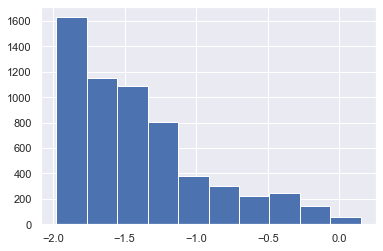

In [32]:
plt.hist(df_accel_filtered['vx'])